In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
import seaborn as sns

# Load data
path_to_source_data_dir = '../results/SourceData'

# Load evaluation results
evaluation_results = pd.read_csv(f'{path_to_source_data_dir}/main_results/evaluation_results.csv', index_col=0)
# Additional results for PDX_Bruna and BeatAML2
external_cs_results = pd.read_csv(f'{path_to_source_data_dir}/infer_pdx_beat/evaluation_results.csv', index_col=0)
external_cs_results = external_cs_results[external_cs_results['rand_setting'] != "predictions"]
dipk_cs_results = pd.read_csv(f'{path_to_source_data_dir}/dipk_pdx_beat/evaluation_results.csv', index_col=0)
dipk_cs_results = dipk_cs_results[dipk_cs_results['rand_setting'] != 'predictions']
evaluation_results = pd.concat([evaluation_results, external_cs_results])
evaluation_results = pd.concat([evaluation_results, dipk_cs_results])

In [2]:
# Custom Plotly colors
custom_colors = [
    '#636EFA', '#FFA15A', '#00CC96', '#AB63FA', '#FECB52', '#19D3F3', '#FF6692'
]

# Define font size settings
size = 10

def set_global_fontsize(increment=2, base=12):
    plt.rcParams.update({
        'font.size': base + increment,
        'axes.titlesize': base + increment + 1,
        'axes.labelsize': base + increment,
        'xtick.labelsize': base + increment - 1,
        'ytick.labelsize': base + increment - 1,
        'legend.fontsize': base + increment - 3,
        'font.family': 'Helvetica Neue'  # Set font to Helvetica Neue
    })

set_global_fontsize(8)

# Shared settings
models_to_keep = {"DIPK", "SimpleNeuralNetwork", "RandomForest", "NaiveMeanEffectsPredictor", "GradientBoosting"}
model_order = ["RandomForest", "DIPK", "SimpleNeuralNetwork", "NaiveMeanEffectsPredictor", "GradientBoosting"]
datasets_to_keep = ["CTRPV2", "CTRPV1", "CCLE", "GDSC1", "GDSC2", "BEATAML2", "PDX"]

# ======================== Transposed Pearson Violin Plot ========================
metric = "Pearson"  # Updated to use "Pearson" metric
df = evaluation_results[
    (evaluation_results[metric].notnull()) & (evaluation_results["test_mode"] == "LCO")
].copy()
df['rand_setting'] = df['rand_setting'].str.replace("cross-study-", "", regex=False).str.upper()
df['rand_setting'] = df['rand_setting'].replace({"PREDICTIONS": "CTRPV2"})
df = df[df['rand_setting'].isin(datasets_to_keep)]
df = df[df['algorithm'].isin(models_to_keep)]
df['algorithm'] = df['algorithm'].replace({"SimpleNeuralNetwork": "Simple\nNeural\nNetwork", "NaiveMeanEffectsPredictor": "Naive\nMean\nEffects\nPredictor", "GradientBoosting": "Gradient\nBoosting", "DIPK": "DIPK", "RandomForest": "Random\nForest"})
df['algorithm'] = pd.Categorical(df['algorithm'], categories=["Random\nForest", "DIPK", "Simple\nNeural\nNetwork",  "Gradient\nBoosting", "Naive\nMean\nEffects\nPredictor",], ordered=True)

df['rand_setting'] = pd.Categorical(df['rand_setting'], categories=datasets_to_keep, ordered=True)

/var/folders/3x/f8j9tddj7flfxt9zx1gkws1m0000gn/T/ipykernel_73612/3416035913.py:23: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax1 = sns.violinplot(
/var/folders/3x/f8j9tddj7flfxt9zx1gkws1m0000gn/T/ipykernel_73612/3416035913.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_stats = df[df['algorithm'] == baseline_model].groupby('rand_setting')[metric].agg(['mean', 'std'])


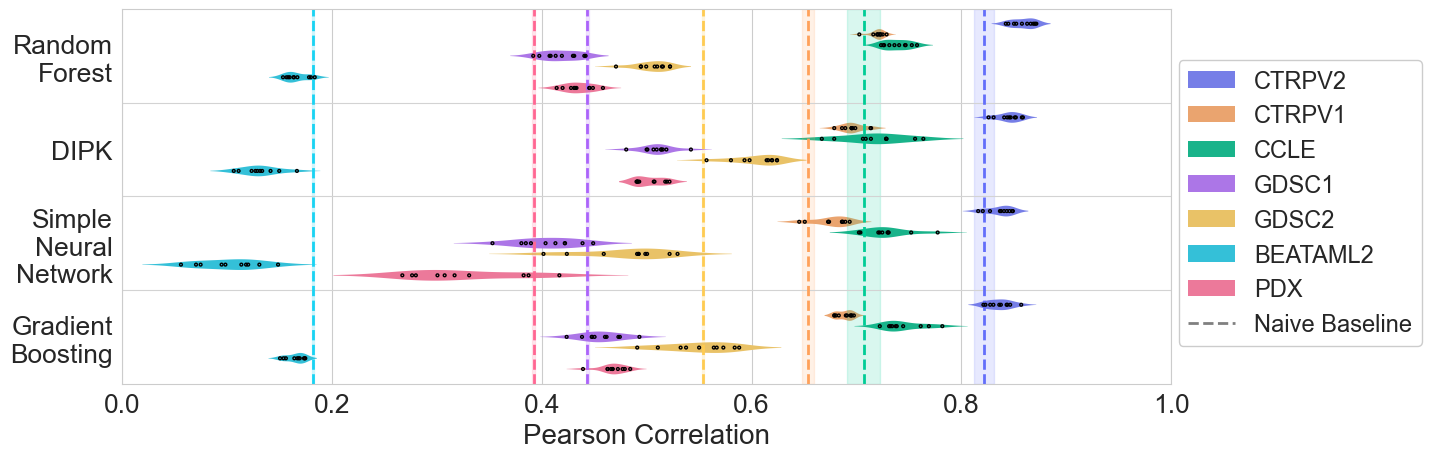

In [3]:
plt.figure(figsize=(15, 5))

# Filter out the baseline model from the violin plot data
baseline_model = "Naive\nMean\nEffects\nPredictor"
violin_df = df[df['algorithm'] != baseline_model].copy()

# Update algorithm category order without baseline model
visible_algorithms = [alg for alg in model_order if alg != "NaiveMeanEffectsPredictor"]
pretty_alg_names = {
    "SimpleNeuralNetwork": "Simple\nNeural\nNetwork",
    "NaiveMeanEffectsPredictor": "Naive\nMean\nEffects\nPredictor",
    "GradientBoosting": "Gradient\nBoosting",
    "DIPK": "DIPK",
    "RandomForest": "Random\nForest"
}
violin_df['algorithm'] = violin_df['algorithm'].cat.remove_categories([baseline_model])
violin_df['algorithm'] = pd.Categorical(violin_df['algorithm'],
    categories=[pretty_alg_names[m] for m in visible_algorithms],
    ordered=True
)

# Create the violin plot
ax1 = sns.violinplot(
    data=violin_df,
    y='algorithm',
    x=metric,
    hue='rand_setting',
    palette=custom_colors[:len(datasets_to_keep)],
    dodge=True,
    inner="point",
    scale="width",
    linewidth=1,
    edgecolor='none'
)

# Set the border color for inner points
for i, artist in enumerate(ax1.collections):
    if isinstance(artist, PathCollection):
        artist.set_edgecolor("black")

# Add horizontal dotted lines between remaining models
for i in range(len(violin_df['algorithm'].cat.categories) - 1):
    plt.axhline(y=i + 0.5, color='lightgrey', linestyle='-', linewidth=.8)

# Compute baseline means and stds for each dataset
baseline_stats = df[df['algorithm'] == baseline_model].groupby('rand_setting')[metric].agg(['mean', 'std'])

# Add vertical lines and shaded std regions
for i, dataset in enumerate(datasets_to_keep):
    if dataset in baseline_stats.index:
        mean_val = baseline_stats.loc[dataset, 'mean']
        std_val = baseline_stats.loc[dataset, 'std']
        
        # Add vertical line for mean
        ax1.axvline(x=mean_val, color=custom_colors[i], linestyle='--', linewidth=2, label=f'{dataset} Baseline')
        
        # Add shaded region for ±1 std
        ax1.axvspan(mean_val - std_val, mean_val + std_val,
                    color=custom_colors[i], alpha=0.15)

# After plotting the baseline vertical lines and shaded areas:


# Get the current legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Remove the individual baseline model entries from the legend
handles = [handle for handle, label in zip(handles, labels) if 'Baseline' not in label]
labels = [label for label in labels if 'Baseline' not in label]

# Now add a single "Naive Baseline" entry in a neutral gray color
handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=2))  # Line for baseline
labels.append('Naive Baseline')

# Create the legend with the modified handles and labels
ax1.legend(handles=handles, labels=labels, loc='lower right', bbox_to_anchor=(1.25, 0.07), framealpha=1)

plt.ylabel(None)
plt.xlim(0, 1)
plt.xlabel(f"{metric} Correlation")

plt.tight_layout()
plt.savefig("figures/cross_study_violins_vertical_baseline.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()
